# walkthrough of bivariate copula (bicop) dataclasses and factory methods.

- Most workflow

the function `tvc.bicop.vcp_from_obs` takes bicop observations (of shape $(n,2)$ and values inside $(0,1)$), to fit every family (and implied rotations) in `tpl_fam`, using fit methods (default `'itau'`), and select the best bicop model using selection criteria (default `'aic'`), then returns an object of data class `DataBiCop`.

the data class `DataBiCop` stores fitted parameters and other outcomes, and can call functions (static methods) from corresponding families.

- A bit extra

Each bicop family class has static methods including `cdf_0`, `pdf_0`, `hfunc1_0`, `hinv1_0`, `l_pdf_0`, `par2tau_0`, `tau2par_0` and inherited their rotated versions from `BiCopAbstract`.


In [1]:
import matplotlib.pyplot as plt
import torch

import torchvinecopulib as tvc

print(f"cuda (GPU) avail? {torch.cuda.is_available()}\n")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
for _ in tvc.bicop.__all__:
    print(f"\n{_}")
    print(tvc.bicop.__getattribute__(_).__doc__)

print(f"\nbicop fam avail: {tvc.bicop.ENUM_FAM_BICOP._member_names_}")

cuda (GPU) avail? True


DataBiCop
Dataclass for a bivariate copula.

    The default BiCopData is an Independent BiCop.

    num_obs = 1 by default, to avoid nan for bic.
    Can modify num_obs during instantiation, for accurate bic calculation
    

bcp_from_obs
factory method to make a bivariate copula dataclass object, fitted from observations

    :param obs_bcp: bivariate copula obs, of shape (num_obs, 2) with values in [0, 1]
    :type obs_bcp: torch.Tensor
    :param tau: Kendall's tau of the observations, defaults to None for the function to estimate
    :type tau: float, optional
    :param mtd_fit: parameter estimation method, either 'itau' (inverse of tau) or 'mle' (maximum likelihood estimation); defaults to "itau"
    :type mtd_fit: str, optional
    :param mtd_mle: optimization method for mle as used by scipy.optimize.minimize, defaults to "COBYLA"
    :type mtd_mle: str, optional
    :param mtd_sel: model selection criterion, either 'aic' or 'bic'; defaults to "aic"
   

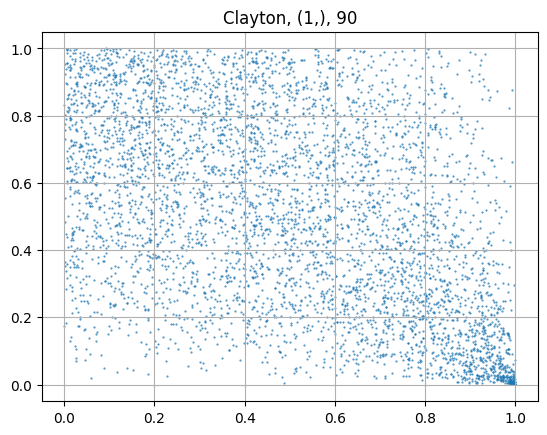

In [2]:
# simulate from a bcp with given family, parameter, rotation
fam, par, rot = "Clayton", (1,), 90
V_bcp = tvc.bicop.DataBiCop(fam=fam, par=par, rot=rot).sim(num_sim=5000, device=DEVICE, seed=0)
# visualization
plt.scatter(*V_bcp.T.cpu(), s=0.3, alpha=0.8)
plt.title(f"{fam}, {par}, {rot}")
plt.grid()

## factory function


DataBiCop(fam='Clayton', negloglik=-912.3090014252416, num_obs=5000, par=(0.9549835244447302,), rot=90)

{'fam': 'Clayton',
 'rot': 90,
 'tau': -0.3232,
 'par': (0.955,),
 'num_obs': 5_000,
 'negloglik': -912.309,
 'aic': -1822.618,
 'bic': -1816.1008}


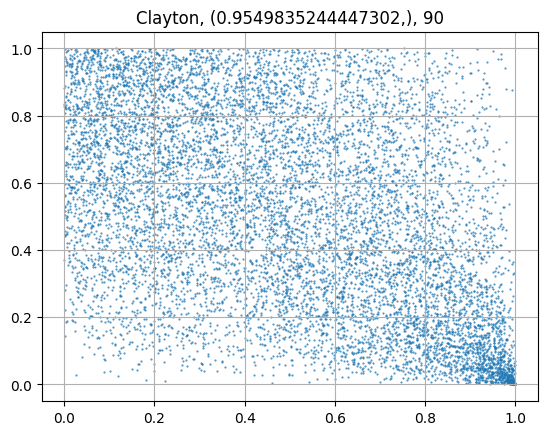

In [3]:
# make a DataBiCop object (from fitting the bicop obs);
mdl_bcp = tvc.bicop.bcp_from_obs(V_bcp)
display(mdl_bcp)
print(mdl_bcp)
# use the fitted model to simulation;
V_bcp = mdl_bcp.sim(num_sim=10000, device=DEVICE, seed=1)
# visualization
plt.scatter(*V_bcp.T.cpu(), s=0.3, alpha=0.8)
plt.title(f"{mdl_bcp.fam}, {mdl_bcp.par}, {mdl_bcp.rot}")
plt.grid()

## dataclass: "cdf", "hfunc1", "hfunc2", "hinv1", "hinv2", "l_pdf"


In [4]:
for _ in ("cdf", "hfunc1", "hfunc2", "hinv1", "hinv2", "l_pdf"):
    print(f"{_}\t{mdl_bcp.__getattribute__(_)(V_bcp)}")

cdf	tensor([[0.0474],
        [0.4390],
        [0.3763],
        ...,
        [0.5354],
        [0.0269],
        [0.0092]], device='cuda:0', dtype=torch.float64)
hfunc1	tensor([[0.2598],
        [0.8629],
        [0.8907],
        ...,
        [0.9168],
        [0.1081],
        [0.0490]], device='cuda:0', dtype=torch.float64)
hfunc2	tensor([[0.7139],
        [0.7550],
        [0.6509],
        ...,
        [0.8309],
        [0.2048],
        [0.1007]], device='cuda:0', dtype=torch.float64)
hinv1	tensor([[0.0463],
        [0.8487],
        [0.9155],
        ...,
        [0.8728],
        [0.3907],
        [0.3490]], device='cuda:0', dtype=torch.float64)
hinv2	tensor([[0.9542],
        [0.3699],
        [0.2757],
        ...,
        [0.4177],
        [0.4665],
        [0.4341]], device='cuda:0', dtype=torch.float64)
l_pdf	tensor([[ 1.0114],
        [-0.0084],
        [ 0.1415],
        ...,
        [-0.1755],
        [-0.2510],
        [-0.6485]], device='cuda:0', dtype=torch.float64